In [16]:
import pandas as pd

from alphax.dataset import DATASET_DIR

train_data = pd.read_csv(f"{DATASET_DIR}/candle/5m/DOGE_USDT:USDT_2024-01-01 00:00:00_2024-07-01 00:00:00.csv")

# 删除不需要的列
train_data.drop(columns=["high", "low", "open","volume"], inplace=True)
train_data.head()

,timestamp,close
0,2023-12-31 16:00:00,0.09018
1,2023-12-31 16:05:00,0.09023
2,2023-12-31 16:10:00,0.09044
3,2023-12-31 16:15:00,0.09043
4,2023-12-31 16:20:00,0.09046


In [27]:
# 构建涨幅率，涨幅率 = (后一行的close - 当前一行close) / 当前一行的close
train_data['price_rate'] =  (train_data["close"].shift(-1) - train_data["close"]) / train_data["close"]
train_data['target'] = train_data['price_rate'] > 0.002
train_data['is_up'] = train_data['price_rate'] > 0
# 统计一下target为true的数量
train_data['is_up'].value_counts()
train_data['target'].value_counts()


target
False    43497
True      8969
Name: count, dtype: int64

In [18]:
from talib import MACD

macd, macd_signal, macd_hist = MACD(train_data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
train_data['macd'] = macd
train_data['signal'] = macd_signal
train_data['hist'] = macd_hist

train_data.dropna(inplace=True)

In [19]:
from alphax.core.utils.math_util import MathUtil
import numpy as np


train_data['golden_cross'] = np.where((train_data['macd'].shift(1) < train_data['signal'].shift(1)) & 
                                      (train_data['macd'] > train_data['signal']), 1, 0)

train_data.head()


,timestamp,close,price_rate,target,is_up,macd,signal,hist,golden_cross
33,2023-12-31 18:45:00,0.09053,-0.000221,False,False,0.000033,0.000040,-0.000007,0
34,2023-12-31 18:50:00,0.09051,0.000331,False,True,0.000027,0.000037,-0.000010,0
35,2023-12-31 18:55:00,0.09054,0.000221,False,True,0.000024,0.000034,-0.000011,0
36,2023-12-31 19:00:00,0.09056,0.000110,False,True,0.000023,0.000032,-0.000009,0
37,2023-12-31 19:05:00,0.09057,-0.000994,False,False,0.000023,0.000030,-0.000007,0


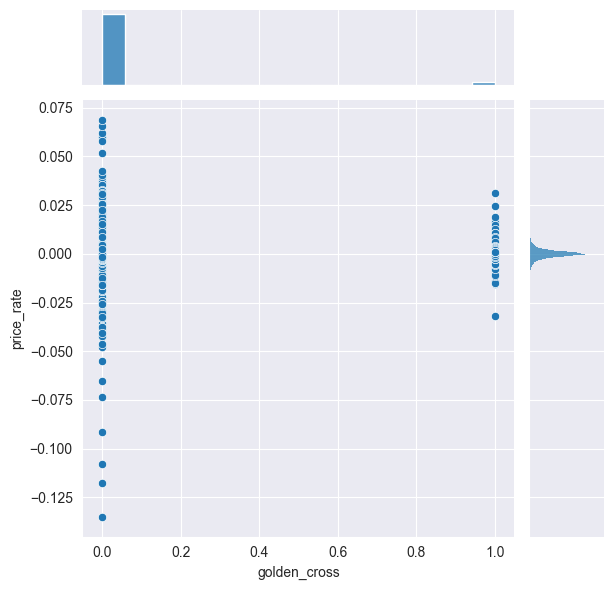

In [20]:
# 用plot 展示一下 price_diff_rate 在 macd_hist_slope 下的分布
import matplotlib.pyplot as plt
import seaborn as sns
# 求一个数字的绝对值

# filtered_df = train_data[train_data['golden_cross'] == 1 ]
# filtered_df = train_data[train_data['macd_hist_slope']]
filtered_df = train_data
sns.jointplot(x='golden_cross', y='price_rate', data=filtered_df, kind='scatter')
plt.show()


In [24]:
filtered_df = train_data[train_data['golden_cross'] == 1 ]
# 统计一下 filtered_df 中 target 为true的数量
filtered_df['target'].value_counts()


target
False    1769
True      355
Name: count, dtype: int64